# Data Analysis

We decided to perform a classification analysis using the Department attribute as the target of it. This classification was performed with 4 different methods:


1.   Logistic regression
2.   Decision tree
3. Random Forest
4. Ada Boost





# Mount drive

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. ENVIRONMENT DETECTION & CONFIGURATION ---
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("☁️ Environment detected: Google Colab")

    # Silent installation of dependencies
    print("⚙️ Installing dependencies...")
    !sudo apt-get install -y -q libcairo2-dev pkg-config python3-dev
    !pip install -q jupyter-contrib-nbextensions
    !jupyter nbextension enable --py widgetsnbextension

    # Cloning from GitHub directly
    !git clone https://github.com/ABADIAb/moma-artwork-data-quality-pipeline.git
    DATA_PATH = 'moma-artwork-data-quality-pipeline/data'

else:
    print("💻 Environment detected: Local")
    # Assuming notebook is in 'notebooks/' folder, data is one level up
    DATA_PATH = '../data'

☁️ Environment detected: Google Colab
⚙️ Installing dependencies...
Reading package lists...
Building dependency tree...
Reading state information...
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  javascript-common libjs-sphinxdoc libjs-underscore python3.10-dev
Suggested packages:
  apache2 | lighttpd | httpd
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  javascript-common libjs-sphinxdoc libjs-underscore pkg-config python3-dev
  python3.10-dev
0 upgraded, 6 newly installed, 2 to remove and 41 not upgraded.
Need to get 508 kB/844 kB of archives.
After this operation, 1,253 kB of additional disk space will be used.
Ign:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3.10-dev am

# Import libraries

In [2]:
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from astropy.time import Time

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Classification methods
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Evaluation Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# Data Loading and Config

In [3]:
# --- 2. DATA LOADING ---
# Define file paths using os.path.join for cross-platform compatibility
dirty_data_path = os.path.join(DATA_PATH, 'artworks.csv')
clean_data_path = os.path.join(DATA_PATH, 'artworks_clean.csv')

# Verify files exist before loading
if os.path.exists(dirty_data_path) and os.path.exists(clean_data_path):
    print(f"✅ Loading data from: {DATA_PATH}")
    df_artwork_dirty = pd.read_csv(dirty_data_path)
    df_artwork_clean = pd.read_csv(clean_data_path)
    print(f"   - Dirty dataset shape: {df_artwork_dirty.shape}")
    print(f"   - Clean dataset shape: {df_artwork_clean.shape}")
else:
    print(f"❌ ERROR: Data files not found at: {DATA_PATH}")
    print("   -> Please verify the 'data' folder contains 'artworks.csv' and 'artworks_clean.csv'")

# Define target variable and seed
target_variable = 'Department'
np.random.seed(1234)

df_artwork_clean.info()

✅ Loading data from: /content/drive/MyDrive/DataQualityTemporal/data
   - Dirty dataset shape: (130262, 21)
   - Clean dataset shape: (84789, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84789 entries, 0 to 84788
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Artwork ID            84789 non-null  int64  
 1   Title                 84789 non-null  object 
 2   Num. artists          84789 non-null  int64  
 3   Main artist ID        84789 non-null  int64  
 4   Secondary artists ID  84789 non-null  object 
 5   Name                  84789 non-null  object 
 6   Start year            84789 non-null  int64  
 7   End year              84789 non-null  int64  
 8   Medium                84789 non-null  object 
 9   Acquisition Date      84789 non-null  object 
 10  Credit                84789 non-null  object 
 11  Catalogue             84789 non-null  int64  
 12  Department            8478

# Preprocessing for analysis

## Preprocessing for clean dataset

In [4]:
# Prepare Acquisition Date for Analysis
df_artwork_clean.iloc[df_artwork_clean['Acquisition Date'] == 'Unspecified'] = 0

# Extract numerical features
df_artwork_clean['Acquisition Year'] = df_artwork_clean['Acquisition Date'].astype(str).str.split('-').str[0].fillna(df_artwork_clean["Acquisition Date"].mode()[0].split('-')[0]).astype(int)
df_artwork_clean = df_artwork_clean.drop('Acquisition Date', axis=1)

In [5]:
# Drop columns: ID, Title, Name, etc
df_artwork_clean = df_artwork_clean.drop(columns=['Artwork ID', 'Credit', 'Classification', 'Title','Main artist ID', 'Secondary artists ID', 'Name', 'Medium'])

# Convert categorical values of the department to integers using factorize
df_artwork_clean['Department'], unique_categories = pd.factorize(df_artwork_clean['Department'])

df_artwork_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84789 entries, 0 to 84788
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Num. artists      84789 non-null  int64  
 1   Start year        84789 non-null  int64  
 2   End year          84789 non-null  int64  
 3   Catalogue         84789 non-null  int64  
 4   Department        84789 non-null  int64  
 5   Height (cm)       84789 non-null  float64
 6   Width (cm)        84789 non-null  float64
 7   Duration (s)      84789 non-null  float64
 8   Acquisition Year  84789 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 5.8 MB


## Preprocessing for dirty dataset

In [6]:
df_artwork_dirty = df_artwork_dirty.drop(columns=['Artwork ID', 'Acquisition Date', 'Date', 'Name', 'Dimensions', 'Medium', 'Credit', 'Classification', 'Title','Artist ID', 'Object Number', 'Diameter (cm)', 'Circumference (cm)', 'Length (cm)', 'Depth (cm)', 'Weight (kg)'])

df_artwork_dirty['Catalogue'] = df_artwork_dirty['Catalogue'].replace({'Y': 1, 'N': 0})

df_artwork_dirty = df_artwork_dirty.fillna(0)

df_artwork_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130262 entries, 0 to 130261
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Catalogue     130262 non-null  int64  
 1   Department    130262 non-null  object 
 2   Height (cm)   130262 non-null  float64
 3   Width (cm)    130262 non-null  float64
 4   Duration (s)  130262 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 5.0+ MB


/tmp/ipython-input-2820322987.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_artwork_dirty['Catalogue'] = df_artwork_dirty['Catalogue'].replace({'Y': 1, 'N': 0})


# Analysis


## Analysis clean dataset

In [ ]:
input_variables = df_artwork_clean.columns[df_artwork_clean.columns!=target_variable]

X = df_artwork_clean[input_variables]
y = df_artwork_clean[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.20,
                                                    random_state=1234,
                                                    shuffle=True)

In [ ]:
n_estimators = 30

methods = {
    'Logistic Regression': LogisticRegression(penalty="l2", C=100, random_state=1234, max_iter=300, solver="lbfgs"),
    'Decision Tree':DecisionTreeClassifier(max_depth=None),
    'Random Forest':RandomForestClassifier(n_estimators=n_estimators,max_depth=None,oob_score=True),
    'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=n_estimators)
}

In [ ]:
roc_results = {}
feature_importance_model = {}

method = []
accuracy = []
precision = []
recall = []
f1 = []
auc = []

for method_name in methods:

    clf = methods[method_name];

    clf.fit(X_train, y_train)

    # if the mode can return an evaluation of feature importance we store it to analyze it later
    if hasattr(clf, 'feature_importances_'):
            feature_importance_model[method_name] = (clf, clf.feature_importances_)

    # compute the prediction which, for probabilistic classifiers, is using a threshold of 0.5
    y_pred = clf.predict(X_test)

    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='micro'))
    recall.append(recall_score(y_test, y_pred, average='micro'))
    f1.append(f1_score(y_test, y_pred, average='micro'))

    print("%40s"%method_name)
    print("========================================")
    print("\t      Accuracy  %.3f"%accuracy_score(y_test, y_pred))
    print("\t      Precision %.3f"%precision_score(y_test, y_pred, average='micro'))
    print("\t      Recall    %.3f"%recall_score(y_test, y_pred, average='micro'))
    print("\t      F1        %.3f"%f1_score(y_test, y_pred, average='micro'))
    print("\n")

    method.append(method_name)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                     Logistic Regression
	      Accuracy  0.565
	      Precision 0.565
	      Recall    0.565
	      F1        0.565


                           Decision Tree
	      Accuracy  0.809
	      Precision 0.809
	      Recall    0.809
	      F1        0.809


                           Random Forest
	      Accuracy  0.847
	      Precision 0.847
	      Recall    0.847
	      F1        0.847


                               Ada Boost
	      Accuracy  0.636
	      Precision 0.636
	      Recall    0.636
	      F1        0.636




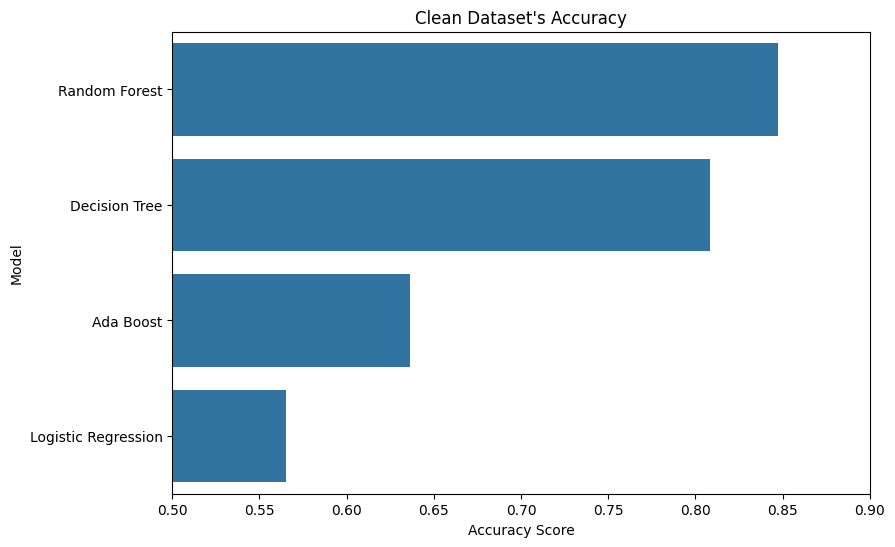

In [ ]:
result_summary = pd.DataFrame({'Model': method,
                               'Accuracy':accuracy,
                               'Precision': precision,
                               'Recall': recall,
                               'F1':f1 })

f, axe = plt.subplots(1,1, figsize=(9,6))

result_summary.sort_values(by=['Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Accuracy', y='Model', data = result_summary, ax = axe)
axe.set_xlabel('Accuracy Score')
axe.set_ylabel('Model')
axe.set_title("Clean Dataset's Accuracy")
axe.set_xlim(0.5, 0.9)
plt.show()

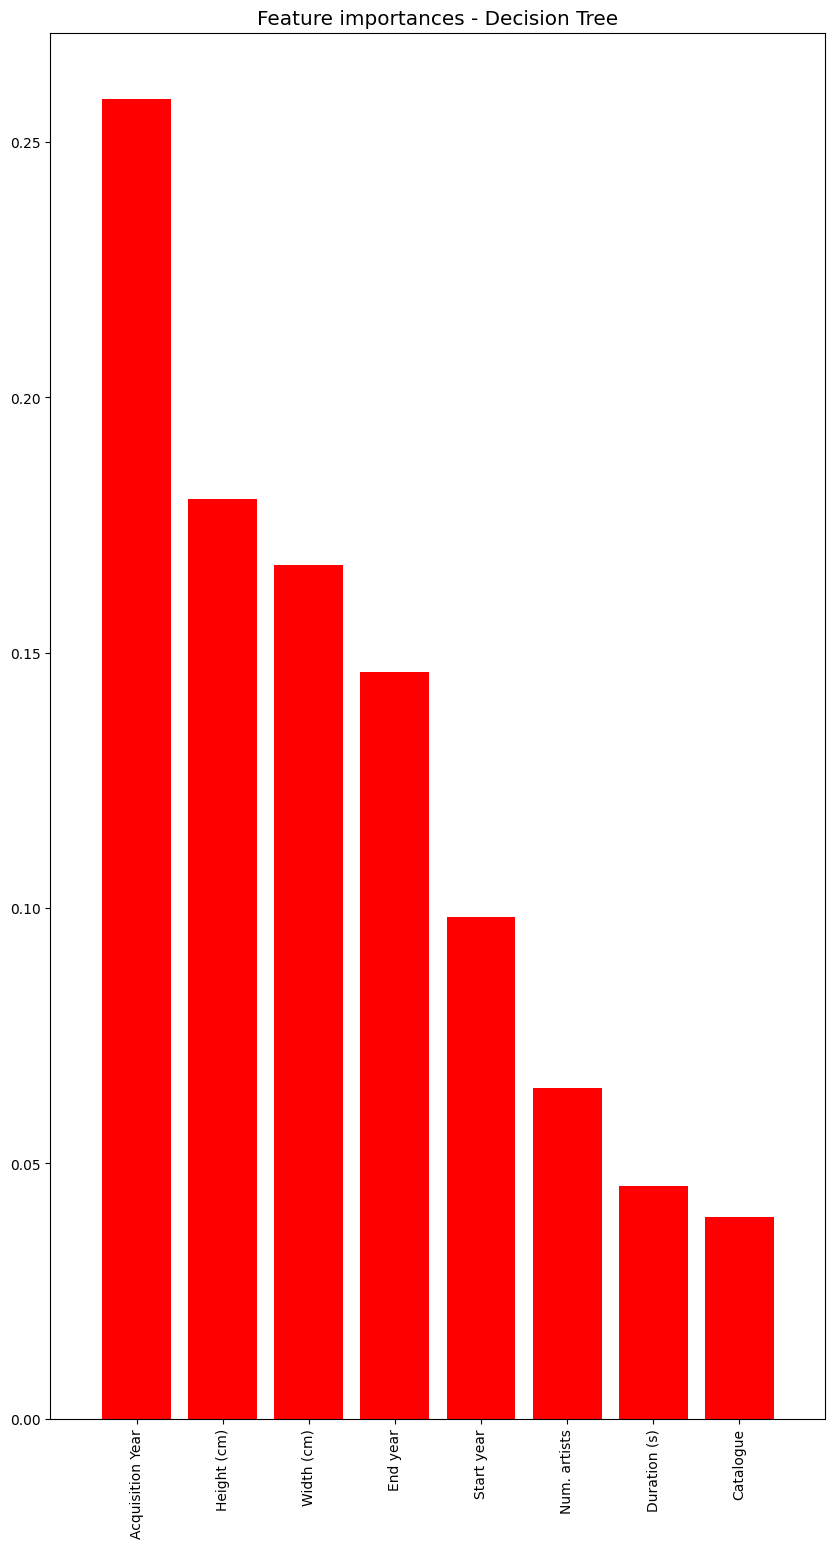

In [ ]:
plot_idx = 1

plt.subplots(1 ,1, figsize=(10,18))
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)

model = feature_importance_model['Decision Tree'][0]

# importance of features
importances = model.feature_importances_

# indeces of the variables
indices = np.argsort(importances)[::-1]

plt.title("Feature importances - "+ 'Decision Tree')
plt.xticks(range(X.shape[1]),X.columns[indices],rotation='vertical')

plt.xlim([-1, X.shape[1]])

plt.bar(range(X.shape[1]), importances[indices], color="r")
plot_idx = plot_idx + 1

plt.show()

## Analysis dirty dataset

In [ ]:
input_variables = df_artwork_dirty.columns[df_artwork_dirty.columns!=target_variable]

X = df_artwork_dirty[input_variables]
y = df_artwork_dirty[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.20,
                                                    random_state=1234,
                                                    shuffle=True)

In [ ]:
n_estimators = 30

methods = {
    'Logistic Regression': LogisticRegression(penalty="l2", C=100, random_state=1234, max_iter=300, solver="lbfgs"),
    'Decision Tree':DecisionTreeClassifier(max_depth=None),
    'Random Forest':RandomForestClassifier(n_estimators=n_estimators,max_depth=None,oob_score=True),
    'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=n_estimators)
}

In [ ]:
roc_results = {}
feature_importance_model = {}

method = []
accuracy = []
precision = []
recall = []
f1 = []
auc = []

for method_name in methods:

    clf = methods[method_name];

    clf.fit(X_train, y_train)

    # if the mode can return an evaluation of feature importance we store it to analyze it later
    if hasattr(clf, 'feature_importances_'):
            feature_importance_model[method_name] = (clf, clf.feature_importances_)

    # compute the prediction which, for probabilistic classifiers, is using a threshold of 0.5
    y_pred = clf.predict(X_test)

    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='micro'))
    recall.append(recall_score(y_test, y_pred, average='micro'))
    f1.append(f1_score(y_test, y_pred, average='micro'))

    print("%40s"%method_name)
    print("========================================")
    print("\t      Accuracy  %.3f"%accuracy_score(y_test, y_pred))
    print("\t      Precision %.3f"%precision_score(y_test, y_pred, average='micro'))
    print("\t      Recall    %.3f"%recall_score(y_test, y_pred, average='micro'))
    print("\t      F1        %.3f"%f1_score(y_test, y_pred, average='micro'))
    print("\n")

    method.append(method_name)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                     Logistic Regression
	      Accuracy  0.475
	      Precision 0.475
	      Recall    0.475
	      F1        0.475


                           Decision Tree
	      Accuracy  0.637
	      Precision 0.637
	      Recall    0.637
	      F1        0.637


                           Random Forest
	      Accuracy  0.667
	      Precision 0.667
	      Recall    0.667
	      F1        0.667


                               Ada Boost
	      Accuracy  0.523
	      Precision 0.523
	      Recall    0.523
	      F1        0.523




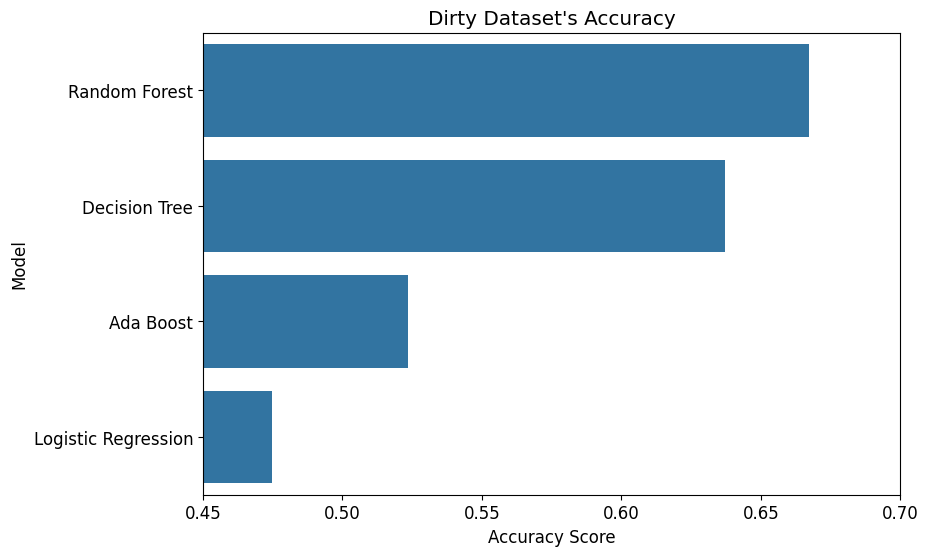

In [ ]:
result_summary = pd.DataFrame({'Model': method,
                               'Accuracy':accuracy,
                               'Precision': precision,
                               'Recall': recall,
                               'F1':f1 })

f, axe = plt.subplots(1,1, figsize=(9,6))

result_summary.sort_values(by=['Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Accuracy', y='Model', data = result_summary, ax = axe)
axe.set_xlabel('Accuracy Score')
axe.set_ylabel('Model')
axe.set_title("Dirty Dataset's Accuracy")
axe.set_xlim(0.45, 0.7)
plt.show()

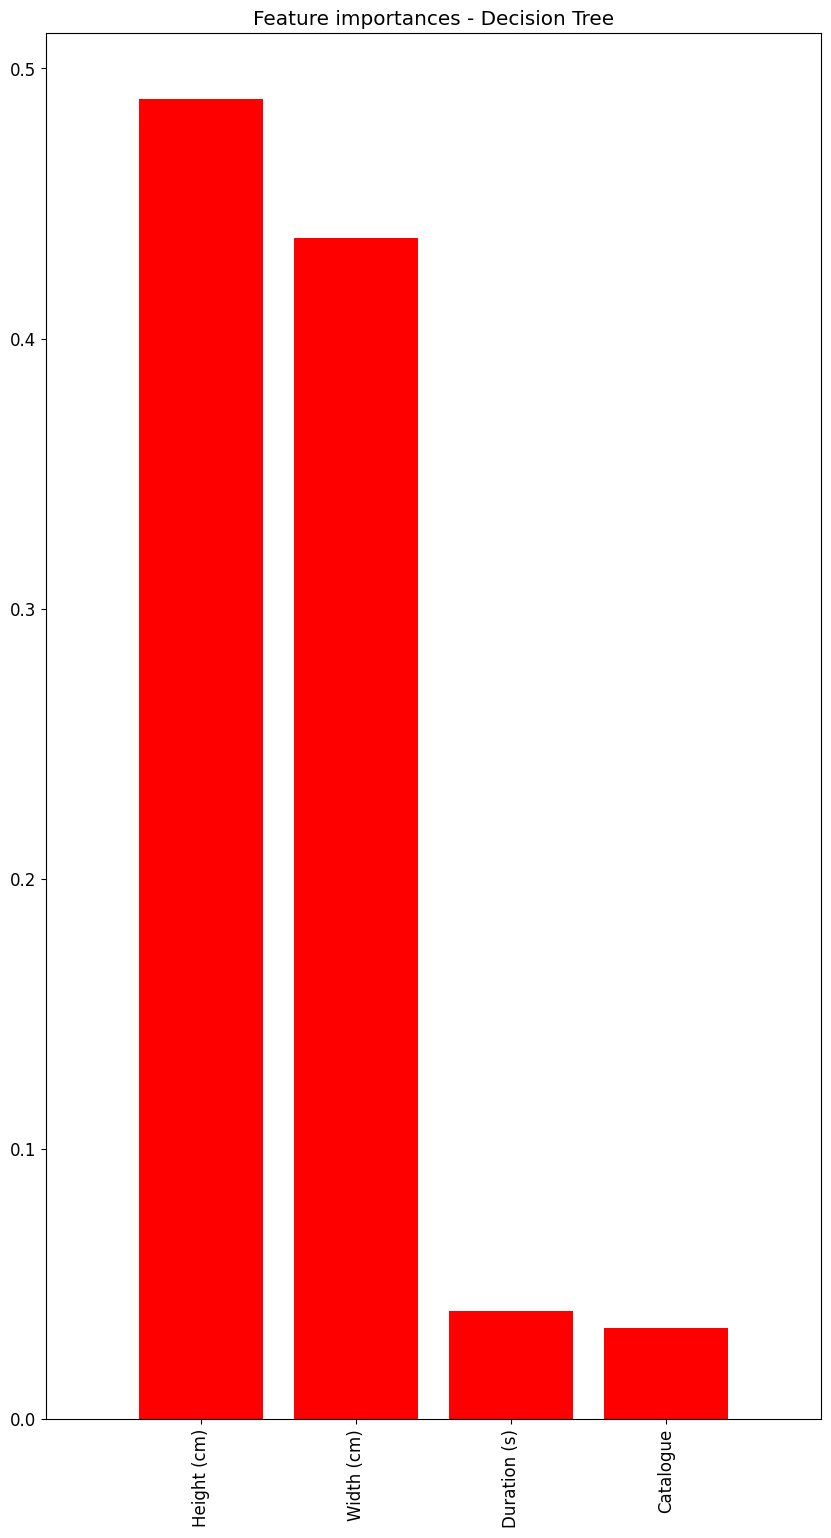

In [ ]:
plot_idx = 1

plt.subplots(1 ,1, figsize=(10,18))
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)

model = feature_importance_model['Decision Tree'][0]

# importance of features
importances = model.feature_importances_

# indeces of the variables
indices = np.argsort(importances)[::-1]

plt.title("Feature importances - "+ 'Decision Tree')
plt.xticks(range(X.shape[1]),X.columns[indices],rotation='vertical')

plt.xlim([-1, X.shape[1]])

plt.bar(range(X.shape[1]), importances[indices], color="r")
plot_idx = plot_idx + 1

plt.show()